# Family Business Report
## Paper 2: Network Trauma

In [1]:
%reset
import warnings
warnings.filterwarnings("ignore")

Once deleted, variables cannot be recovered. Proceed (y/[n])? y



## First analysis

The first analysis will focus on some of the more interesting trauma related scales that were collected in the initial FBR

In [2]:
import pandas as pd
import numpy as np

file = 'C:\\Users\\HearneL\\AnacondaProjects\\FBR_Prevalence\\116_booklet_LJH.xlsx'
df  = pd.read_excel(file,'116_booklet_LJH')

PTSD = df['ICD_PTSD12m']
PTSD = PTSD-1

ID = df['CODE']
TSCL = df.filter(regex='TSCL')
PTCI = df.filter(regex='PTCI')
K5 = df[['K6_sad','K6_nervous','K6_restless','K6_hopeless',
         'K6_everythingeffort']
       ]
Age = df['Age_yr']

### TSCL & PTCI require some more processing to derive the subscales

Now we go through the TSCL and PTCI (as well as the K5) and add the items into subscales, making sure to remove any participants with missing data.

In [3]:
def prepro(df,idx):
    df = df.iloc[:,idx]
    df = df.dropna(axis=0, how='all')
    df = df.apply(lambda x:x.fillna(x.value_counts().index[0]))
    df = df.sum(axis=1)
    return df

K5 = prepro(K5,[0,1,2,3,4])

#Trauma Symptom Checklist subscales
TSCL_diss = prepro(TSCL,[6, 13, 15, 24, 30, 37])
TSCL_anxi = prepro(TSCL,[0, 3, 9, 15, 20, 26, 31, 33, 38])
TSCL_depr = prepro(TSCL,[1, 2, 8, 14, 18, 19, 25, 32, 36])
TSCL_sati = prepro(TSCL,[4, 6, 12, 20, 24, 28, 30])
TSCL_slee = prepro(TSCL,[1, 7, 12, 18, 21, 27])
TSCL_sepr = prepro(TSCL,[4, 8, 10, 16, 22, 28, 34, 39])

#Posttraumatic cognitions inventory 
PTCI_nsel = prepro(PTCI,[1,2,3,4,5,8,11,12,14,15,18,19,22,23,24,26,27,
                         28,30,31,32])
PTCI_nsel = PTCI_nsel/21
PTCI_nwrd = prepro(PTCI,[6,7,9,10,13,16,17,20,21,25,29])
PTCI_nwrd = PTCI_nwrd/11
PTCI_sebl = prepro(PTCI,[0,13,17,20,29])
PTCI_sebl = PTCI_sebl/5

### CIDI data variables

Next, we load in the CIDI and calculate age related variables. Individuals reported their age at the time of event(s), so we search across all of them and find the smallest number.

In [4]:
# CIDI information
df  = pd.read_excel('STATA_booklet_LJH.xlsx','original_STATA')
CIDIage = df[['pt34a','pt36a','pt37a','pt38a','pt39a',
              'pt40a','pt41a','pt42a','pt43a','pt44a','pt45a',
              'pt46a','pt47a','pt48a','pt49a',
              'pt50a','pt50_1a','pt51a','pt52a','pt53a','pt54a',
              'pt64a','pt59b_5']
            ]

CIDITrauma = pd.read_excel('STATA_booklet_LJH.xlsx','trauma_LJH')
CIDITrauma = CIDITrauma.fillna(0)
CIDITrauma[CIDITrauma==5]=0
CIDIfreq = CIDITrauma.sum(axis=1)

#Age related variables
AgeAtFirstTrauma = CIDIage.min(axis=1)

### Create preprocessed file
Finally! We now put together the variables we are interested in and output a .csv file that we will use R to analyze.

In [5]:
data = pd.concat([ID,CIDIfreq,AgeAtFirstTrauma,
                  K5,
                  TSCL_depr,TSCL_anxi,TSCL_diss,
                  TSCL_sati,TSCL_sepr,TSCL_slee,
                  PTCI_nsel,PTCI_nwrd,PTCI_sebl,
                 ],axis=1
                )
data.columns = ['ID','Number of trauma','Age at first trauma',
                'K-5',
                'Depression','Anxiety','Dissociation',
                'Sexual abuse','Sexual problems','Sleep disturbance',
                'Negative self-view','Negative world-view','Self blame',
               ]

dataD = data.dropna(axis=0, how='any')
# z-score the data (not needed but habit, I guess)
cols = list(data.columns)

for col in cols:
    dataD[col] = (dataD[col] - dataD[col].mean())/dataD[col].std(ddof=0)

dataD.to_csv('TraumaEffect_data_wAge_prepro.csv')
finalID = dataD['ID']

## Second analysis
### CIDI PTSD variables

Note could be difficult to compare across this data and MUSP depending on whether they were diagnosed with the DSM or ICD.

...According to the CIDI handbook/DSM IV we can collate data relating to:

- intrusion & reexperiencing (5 questions)
- avoidance & numbing (7 questions)
- hyperarousal (5 questions)

In the cidi participants are asked whether they experience aspects of these variables (across say 5 different questions) for their 'worst' trauma and a 'random' trauma. Here I've taken the total of each, and used the largest number - this is probably more similar to the DSM diagnoses than summing across all.

It's important to note that I'm not including this as a diagnostic procedure - just so that we have some 'baseline' variables that readers would be familiar with.

In [7]:
def DSMprepro(df,df2):
    df[df==5]=0
    df2[df2==5]=0

    df = df.sum(axis = 1)
    df2 = df2.sum(axis = 1)

    df3 = pd.concat([df,df2],axis=1)
    df3 = df3.max(axis=1)
    return df3

df  = pd.read_excel('STATA_booklet_LJH.xlsx','original_STATA')
InRe = df[['pt86','pt87','pt88','pt89','pt90']]
InRe2 = df[['pt222','pt223','pt224','pt225','pt226']]
InRe = DSMprepro(InRe,InRe2)

AvNu = df[['pt68','pt69','pt70','pt70','pt71','pt72','pt73','pt74']]
AvNu2 = df[['pt208','pt209','pt210','pt210','pt211','pt212','pt213','pt214']]
AvNu = DSMprepro(AvNu,AvNu2)

HyAr = df[['pt102','pt103','pt104','pt105','pt106']]
HyAr2 = df[['pt233','pt234','pt235','pt236','pt237']]
HyAr = DSMprepro(HyAr,HyAr2)

### Trauma Incidence variables (binary network)

In [6]:
df  = pd.read_excel('116_booklet_LJH.xlsx','116_booklet_LJH')
CulTrauma = df[["A_STOLENGEN","B_PARENTSTOLENGEN","C_SELFREMOVECIHLD",
               "D_SIBLINGREMOVE","E_CHILDRENTAKEGOVE","F_RACISMDISCRIM",
                "G_FAMILYNOTACCEPT","H_COMMNOTACCEPT"]
               ]
CulTrauma[CulTrauma==2]=0 #cultural traumas are 'reverse' coded , thus:
CulTrauma[CulTrauma==3]=0 #3 = 'don't know'
data = pd.concat([finalID,PTSD,CIDITrauma,CulTrauma],axis=1)
data = data.dropna(axis=0, how='any')
data.to_csv('TraumaEvents_data.csv')

## Demographics and most traumatic event

Before we move on to the next interesting analysis. Let's use the participant's we defined in the first section and calculate the demographic details that are of interest to us.

In [7]:

# number who experienced a traumatic event
print(np.sum(CIDITrauma.sum(axis=1)>0),'/116 experienced a CIDI traumatic event')
print(np.sum(CIDITrauma.sum(axis=1)>0)-len(dataD),'had missing data')
print(len(dataD),'were left in the cohort')
print()

# how many different events did each person experience?
data = pd.concat([finalID,CIDITrauma],axis=1)
data = data.dropna(axis=0, how='any')
data = data.drop(['ID'], axis=1)

for i in range(0,5):
    print(np.sum(data.sum(axis=1)==i),' had experienced ',i,' events.')
print(np.sum(data.sum(axis=1)>=5),' had experienced equal to or greater than 5 events')
print(np.sum(data.sum(axis=1)>=3),' had experienced equal to or greater than 3 events')
print()

# most common events.
print(data.sum(axis = 0)/len(data)*100)

93 /116 experienced a CIDI traumatic event
6 had missing data
87 were left in the cohort

0  had experienced  0  events.
24  had experienced  1  events.
9  had experienced  2  events.
15  had experienced  3  events.
6  had experienced  4  events.
33  had experienced equal to or greater than 5 events
54  had experienced equal to or greater than 3 events

kidnapped                                 9.195402
life threat mva                          18.390805
other life thread accident                8.045977
natural disaster                         25.287356
man made disaster                         6.896552
life threat illness                       6.896552
beaten by parents                        27.586207
beaten by spouse                         49.425287
beaten someone else                      12.643678
mugged                                   17.241379
sexual asault - rape                     37.931034
sexual assault other                     35.632184
someone close unexpectedly die  

## Figure 1

Bargraph of most traumatic events.

In [60]:
df  = pd.read_excel('STATA_booklet_LJH.xlsx','original_STATA')
event = df['pt59']

event = pd.concat([finalID,event],axis=1)
event = event.dropna(axis=0, how='any')
event = event.drop(['ID'], axis=1)

eventCount = pd.DataFrame(event["pt59"].unique())
eventCount['count']=0

for i in range(0,len(eventCount)):
    idx = event == eventCount.iloc[i,0]
   
    eventCount.iloc[i,1] = idx['pt59'].sum()

eventCount = eventCount.sort_values("count",ascending = False)
eventCount

,0,count
4,unexpected death of a loved one,25
9,raped,9
1,witnessed physical fight at home,8
6,beaten up by a spouse or romantic partner,8
7,sexually assaulted,6
11,automobile accident,6
0,stalked,4
8,natural disaster,4
3,beaten up as a child by caregiver,3
16,life-threatening accident,3


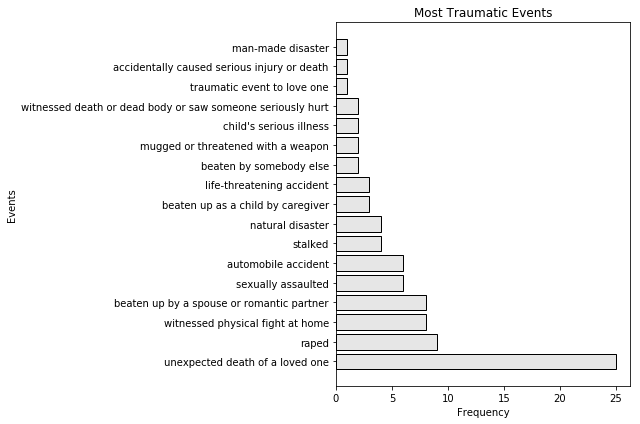

In [99]:
import matplotlib.pyplot as plt
 
# create plot

bar_width = .8
opacity = 1
font = {'family' : 'normal',
        'size'   : 10}

plt.rc('font', **font)
plt.rcParams["figure.figsize"] = [9, 6]

plt.barh(range(len(eventCount)),eventCount['count'], 
                 bar_width,
                 alpha=opacity,
                 color=[0.9,0.9,0.9],
                 edgecolor ='k',
                 label='Frank')

plt.yticks(range(len(eventCount)), eventCount.iloc[:,0])
plt.xlabel('Frequency')
plt.ylabel('Events')
plt.title('Most Traumatic Events')
plt.tight_layout()
plt.savefig('Figure1_test.png')
plt.show()


In [91]:
eventCount.columns

Index([0, 'count'], dtype='object')